# Main Skin Lesion (score de dice ) grid search 

Import librairies

In [1]:
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import sqrt
import copy
import scipy
from scipy import signal
from scipy import ndimage 

## Fonctions auxiliaires 

In [2]:
def load_image(path) : # Charge une image en RGB au lieu de BGR
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return(img)


def RGB2Gray(img) : # RGB vers niveaux de gris 
    imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return(imgGray)



## Hair Removal 

#### Noyaux de détection pour fermeture morphologique

In [3]:
def horizontalKernel(size) : # Noyau horizontal de taille size*size
    if (size % 2 == 0) :
        print("Size must be an odd number")
        return() 
    kernel = np.zeros( (size, size),np.uint8 )
    mid = size//2
    kernel[mid] = np.array([1 for i in range(size)])
    return(kernel)


def verticalKernel(size) : # Noyau vertical
    if (size % 2 == 0) :
        print("Size must be an odd number")
        return()
    kernel = np.zeros( (size, size), np.uint8 )
    mid = size//2
    for i in range(size) :
        kernel[i, mid] = 1
    return(kernel)


def diagLKernel(size) : # Noyau vertical gauche (L), matrice identité
    kernel = np.identity(size, np.uint8)
    return(kernel)


def diagRKernel(size) : # Noyau vertical droit (R)
    kernel = np.zeros( (size, size), np.uint8 )
    for i in range(size) :
        kernel[i, size-i-1] = 1
    return(kernel)


def kernel135R(size) : # Noyau avec angle de 135° à droite (R)
    kernel = np.zeros( (size, size), np.uint8 )
    if (size%2 == 0) : ## Si la taille de la matrice est paire
        mid = size // 2
        count = 0
        x0 = mid 
        y0 = mid-1
        x1 = mid-1
        y1 = mid 
        while ( (x1 >= 0) and (x0 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += -1
                x0 += +1
        return(kernel)
    else :            ## Si la taille de la matrice est impaire
        mid = size // 2
        count = 0
        x0 = mid 
        y0 = mid
        x1 = mid
        y1 = mid 
        while ( (x1 >= 0) and (x0 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += -1
                x0 += +1
        return(kernel)

    
def kernel135L(size) : # Noyau avec angle de 135° à gauche (L)
    kernel = np.zeros( (size, size), np.uint8 )
    if (size%2 == 0) : ## Si la taille de la matrice est paire
        mid = size // 2
        count = 0
        x1 = mid
        y1 = mid
        x0 = mid - 1
        y0 = mid-1
        while ( (x0 >= 0) and (x1 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += 1
                x0 += -1
        return(kernel)
    else :            ## Si la taille de la matrice est impaire
        mid = size // 2
        count = 0
        x0 = mid 
        y0 = mid
        x1 = mid
        y1 = mid 
        while ( (x1 >= 0) and (x0 <= size) and (y1 <= size) and (y0 >= 0) ) :
            kernel[x0, y0] = 1
            kernel[x1, y1] = 1
            y1 += +1
            y0 += -1
            count += 1
            if (count == 2) :
                count = 0
                x1 += 1
                x0 += -1
        return(kernel)



#### Fermetures morphologiques

In [4]:
def closing(kernel, imGray) : # Fermeture morphologique avec openCV. L'mage doit être en nvieaux de gris !
    if (len(np.shape(imGray)) != 2) :
        print("L'image doit être en niveaux de gris")
        return()
    clos = cv2.morphologyEx(imGray,cv2.MORPH_CLOSE, kernel)
    return(clos)


def successiveKernels(imGray, size) : # Applique successivement les différents noyaux de fermeture
    clos = np.copy(imGray)

    kernel = horizontalKernel(size)
    clos = closing(kernel, clos)

    kernel = verticalKernel(size)
    clos = closing(kernel, clos)

    kernel = diagRKernel(size)
    clos = closing(kernel, clos)

    kernel = diagLKernel(size)
    clos = closing(kernel, clos)

    kerenl = kernel135R(size)
    clos = closing(kernel, clos)

    kernel = kernel135L(size)
    clos = closing(kernel, clos)
    
    return(clos)


#### Suppression et interpolation

In [5]:
def createMask(imGray) : # Creér un masque qui localise les poils
    clos = successiveKernels(imGray, 17)
    diff = clos - imGray
    th , mask = cv2.threshold(diff, 21, 1, cv2.THRESH_BINARY);
    return(mask)
    
    
def removeHair(img, mask) : # Mets les pixels supprimés à la valeur 0 pour ne pas influencer l'interpolation
    img1 = np.copy(img)
    for i in range(len(img)) :
        for j in range(len(img[0])) :
            if (mask[i, j] == 1) :
                img1[i, j, 0] = 0
                img1[i, j, 1] = 0
                img1[i, j, 2] = 0
            
    return(img1)


def bilinInterpolation(img1, i, j, mask, taille = 9) : # Interpolation bicubique sur une fenêtre de taille 'taille'
    count_non_mask = 0
    value = np.array([0 ,0 ,0])
    for di in range(-taille, taille + 1) :
        for dj in range(-taille, taille + 1) :
            if (mask[i + di, j + dj] != 1) :
                count_non_mask += 1
                value = value + img1[i + di, j + dj]
    if (count_non_mask == 0) : # évite les divisions par 0
        return(value)
    else :
        return((1/count_non_mask)*value)
    

def interpoleImage(img1, mask, taille = 9) : # Application de l'itnerpolation à chacun des pixels précédemment supprimés
    for i in range(taille, len(img1) - taille) :
        for j in range(taille, len(img1[0]) - taille) :
            if (mask[i, j] == 1) :
                img1[i,j] = bilinInterpolation(img1, i, j, mask, taille)
    return(img1)


#### Fonction globale

In [6]:
def globalRemoveHair(imgGray, currImg) : # Fonction globale qui renvoie l'image originale et l'image après traitement
    mask = createMask(imgGray)
    img1 = removeHair(currImg, mask)
    img1 = interpoleImage(img1, mask, taille = 13)
    final = cv2.medianBlur(img1,7)
    return(final)

def isRemovalNecessary(imgGray): # Renvoie True s'il y a besoin d'appliquer Hair removal
    mask = createMask(imgGray)
    countWhite = sum(sum(mask))
    ratio = countWhite / mask.size
    print(ratio)
    if (ratio > 0.05) :
        return(True)
    else: 
        return(False)

## Réduction du bruit 

Filtre pass-bas circulaire (type pillbox) de rayon 5


In [7]:
def noiseFiltering(currImg): # Filtrage passe-bas circulaire de rayon 5
    dst = np.zeros( np.shape(currImg) )
    X = np.zeros( (len(currImg), len(currImg[0])) )
    Y = np.zeros( (len(currImg), len(currImg[0])) )
    Z = np.zeros( (len(currImg), len(currImg[0])) )
    for i in range(len(dst)) :
        for j in range(len(dst[0])) :
            X[i,j] = currImg[i,j][0]
            Y[i,j] = currImg[i,j][1]
            Z[i,j] = currImg[i,j][2]
    kernel = (1/89)*cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    dstX = cv2.filter2D(X, -1, kernel)
    dstY = cv2.filter2D(Y, -1, kernel)
    dstZ = cv2.filter2D(Z, -1, kernel)
    dst = np.zeros(np.shape(currImg))
    for i in range(len(dst)) :
        for j in range(len(dst[0])) :
            dst[i,j] = [int(dstX[i,j]), int(dstY[i,j]), int(dstZ[i,j])]
    dst = dst.astype(int)     
    return(dst)

def N(currImg):
    kernel = (1/89)*cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    dst = cv2.filter2D(currImg, -1, kernel)
    return(dst)

    
    

## Suppression du carde 

Supprime le cadre en rendant blanc les bordures sombres. Découpage selon des droites. 

In [8]:
def moyenne(im):
    n=len(im)
    m=len(im[0])
    res=0
    for i in range(n):
        for j in range(m):
            res+=im[i][j]
    return res/(m*n)

In [9]:
def retirer_cadre(im):
    n=len(im)
    m=len(im[0])
    new_im=im.copy()
    moy=moyenne(im)
    for i in range(10):
        for j in range(m):
            new_im[i][j]=moy + (255 - moy)/2
            new_im[n-1-i][j]=moy + (255 - moy)/2
    for j in range(10):
        for i in range(n):
            new_im[i][j]=moy + (255 - moy)/2
            new_im[i][m-1-j]=moy + (255 - moy)/2
    for i in range(10,n//2):
        a=10
        while im[i][a]<100+0.3*moy and a<m-1:
            new_im[i][a]=moy + (255 - moy)/2
            a+=1
            if a<m-30:
                for k in range(30):
                    new_im[i][a]=moy + (255 - moy)/2
                    a+=1
    for i in range(10,n//2):
        a=m-1-10
        while im[i][a]<100+0.3*moy and a>1:
            new_im[i][a]=moy + (255 - moy)/2
            a=a-1
            if a>30:
                for k in range(30):
                    new_im[i][a]=moy + (255 - moy)/2
                    a=a-1
            
    
    for i in range(n//2,n-1):
        a=10
        while im[i][a]<100+0.3*moy and a<m-1:
            new_im[i][a]=moy + (255 - moy)/2
            a=a+1
            if a<m-30:
                for k in range(30):
                    new_im[i][a]=moy + (255 - moy)/2
                    a+=1
    for i in range(n//2,n-1):
        a=m-1-10
        while im[i][a]<100+0.3*moy and a>1:
            new_im[i][a]=moy + (255 - moy)/2
            a=a-1
            if a>30:
                for k in range(30):
                    new_im[i][a]=moy + (255 - moy)/2
                    a=a-1
    return new_im

## Ajustement de l'intensité

Ajuste l'intensité : met en blanc et en noir les 1% de chaque extrême et augmente le contraste en étalant l'histogramme

In [10]:
def adjustIntensity(currImg): # Ajuste l'intensité 
    im2 = currImg.flatten()
    im2.sort()
    onePercent = len(im2)//100
    petit = im2[onePercent]
    grand = im2[im2.shape[0] - onePercent]
    newIm = currImg.copy()
    (n, m) = (currImg.shape[0], currImg.shape[1])  
    for i in range(0, n):
        for j in range(0, m):
            if (currImg[i][j] > grand):
                newIm[i][j] = 255
            elif (currImg[i][j]< petit):
                newIm[i][j] = 0
            else:
                newIm[i][j] = int((float(0 + (currImg[i][j] - petit) *255) / float(grand - petit)))
    return (newIm)




## Seuillage par la méthode d'Otsu

In [11]:
def otsu(currImg): # Seuillage par la méthode d'Otsu 
    hist,_ = np.histogram(currImg,range(0,256))
    Variance = np.zeros(256)         
    for k in range (0,256): 
        omega_1 = hist[0:k].sum().astype(float)
        omega_2 = hist[k:-1].sum().astype(float)
        m1 = np.mean(currImg[currImg<=k])
        if (np.isnan(m1)):
            m1 = 0
        m2 = np.mean(currImg[currImg>k])
        if (np.isnan(m2)):
            m2 = 0
        Variance[k] = omega_1 * omega_2 * ( (m1 - m2)**2)
    seuil = np.argmax(Variance)
    
    currImg3=currImg.copy()
    n=len(currImg)
    m=len(currImg[0])
    for i in range(n):
        for j in range(m):
            if currImg[i][j]>seuil:
                currImg3[i][j]=0
            else:
                currImg3[i][j]=255
    return currImg3

## Analyse des composantes connexes 

In [12]:
def connectedComponents2(ots) : # Garde la plus grande composante connexe et celles plus grandes que le dixième de la principale     
    result = np.copy(ots)
    nLabels, labels = cv2.connectedComponents(ots)
    count = np.array([0 for i in range(nLabels)])
    for i in range(len(ots)) :
        for j in range(len(ots[0])) :
            lab = labels[i, j]
            count[lab] += 1
    count = count[1:]
    CC1 = np.argmax(count) + 1
    sizeCC1 = count[CC1 - 1]
    CC = [CC1]
    for k in range(len(count)) :
        sizeCC = count[k]
        if ( (sizeCC > float(sizeCC1)/25) and (k != CC1 - 1) ) :
            CC.append(k+1) 
    for i in range(len(ots)) :
        for j in range(len(ots[0])) :
            lab = labels[i ,j]
            if( (lab in CC)):
                result[i, j] = 255
            else :
                result[i, j] = 0
    return(result, labels)

## Remplissage morphologique 
Remplit le centre du grain de beauté, supprime les trous

In [13]:
def fillHoles(imgBin) : # Applique des fermetures pour "remplir" le grain de beauté
    clos = np.copy(imgBin)
    for size in range(4, 10) :
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size,size))
        clos = closing(kernel, clos)
    return(clos)

## Dessin des contours et final 

In [14]:
def detourer(currImg) : # Détéctection de contours en soustrayant l'image à son dilaté
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(14,14))
    dil = cv2.dilate(currImg, kernel)
    return(dil - currImg)



def displayDetourage(img, det) : # Dessine en rouge les contours sur l'image sans poils
    disp = np.copy(img)
    for i in range(len(img)) :
        for j in range(len(img[0])) :
            contour = det[i, j] 
            if (contour == 255) :
                disp[i, j] = [225, 10, 10]
    return(disp)
                


## Score de Dice


In [15]:
def diceScore(final, trainGray) : # Calcule du score de Dice
    match = 0
    for i in range(len(final)):
        for j in range(len(final[0])) :
            pixelFinal = final[i][j]
            pixelTrain = trainGray[i][j]
            if (pixelTrain == pixelFinal) :
                match += 1
    score = 2*match / (np.size(final) + np.size(trainGray))
    return(score)

## Fonction globale 


In [19]:
def main(path) : # Traitement global, renvoie l'image binaire de détection et l'image avec le détourage dessiné
    img = load_image(path)
    #img = cv2.resize(img,(int(len(img)/2), int(len(img[0])/2)), interpolation = cv2.INTER_AREA) 
    plt.imshow(img)
    plt.show()
    imgGray = np.copy(RGB2Gray(img))
    currImg = np.copy(img)
    a=0
    if (isRemovalNecessary(imgGray)):
        print("oui")
        H = globalRemoveHair(imgGray, currImg)
        a=1
    if a==1:
        plt.imshow(H, cmap = 'gray')
        plt.show()
        N1 = N(H)
    if a==0:
        N1=N(currImg)
    Gris = RGB2Gray(N1)
    sans_cadre = retirer_cadre(Gris)
    plt.imshow(sans_cadre,cmap='gray')
    plt.show()
    C = adjustIntensity(sans_cadre)
    plt.imshow(C,cmap='gray')
    plt.show()
    O = otsu(C)
    plt.imshow(O,cmap='gray')
    plt.show()
    CC = connectedComponents2(O)[0]
    plt.imshow(CC,cmap='gray')
    plt.show()
    F = fillHoles(CC)
    plt.imshow(F,cmap='gray')
    plt.show()
    det = detourer(F)
    det = displayDetourage(img, det)
    return(F, det)







'''path = 'nevus/ISIC_0000095.jpg'
M = main(path)
plt.imshow(M[0], cmap = 'gray')
plt.show()
plt.imshow(M[1], cmap = 'gray')
plt.show()
trainGray = RGB2Gray(load_image('nevus/ISIC_0000095_Segmentation.png'))
trainGray = cv2.resize(trainGray,(int(len(trainGray)/2), int(len(trainGray[0])/2)), interpolation = cv2.INTER_AREA) 
print(diceScore(M[0], trainGray))'''



    
    

"path = 'nevus/ISIC_0000095.jpg'\nM = main(path)\nplt.imshow(M[0], cmap = 'gray')\nplt.show()\nplt.imshow(M[1], cmap = 'gray')\nplt.show()\ntrainGray = RGB2Gray(load_image('nevus/ISIC_0000095_Segmentation.png'))\ntrainGray = cv2.resize(trainGray,(int(len(trainGray)/2), int(len(trainGray[0])/2)), interpolation = cv2.INTER_AREA) \nprint(diceScore(M[0], trainGray))"

## Tests
Fonction de test. Pour chacune des iamges d'un dossier, affcihe les grandes étapes du traitement et calcul à la fin le score de Dice. Ce score est ensuite écrit dans un fichier txt. 

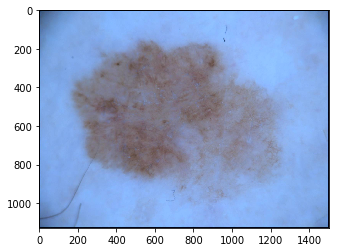

0.006494638448636526


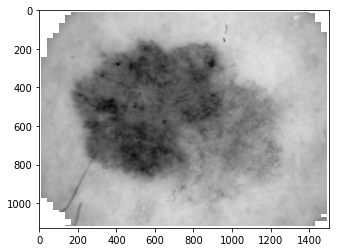

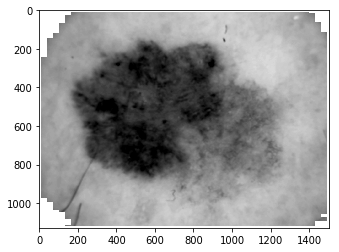

/home/paul/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paul/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


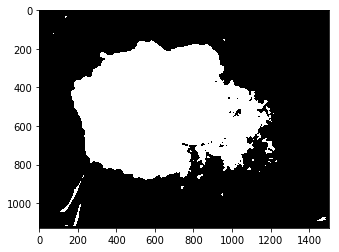

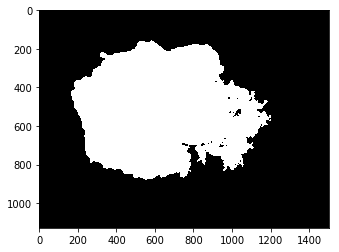

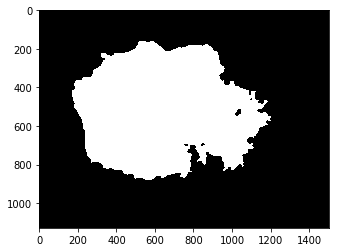

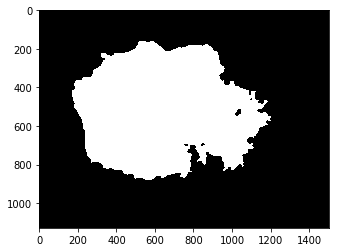

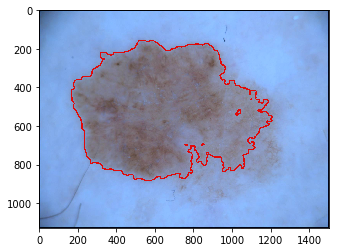

0.8453701260765505


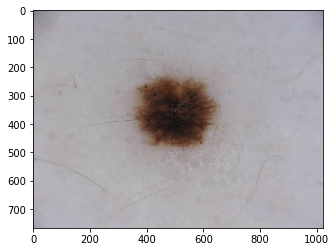

0.00665540635357213


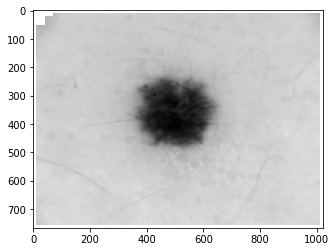

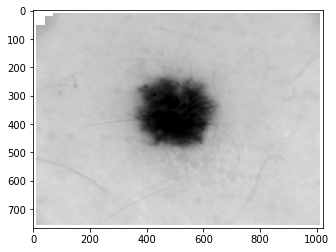

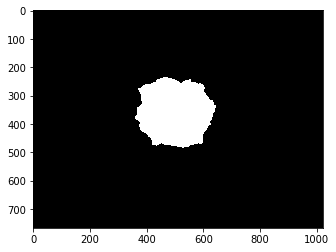

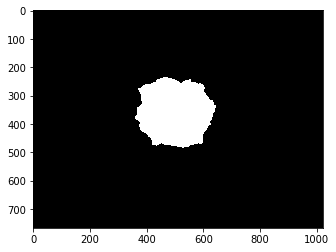

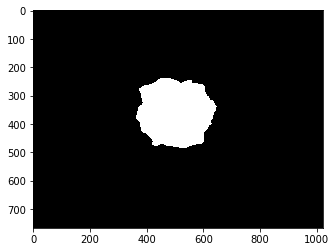

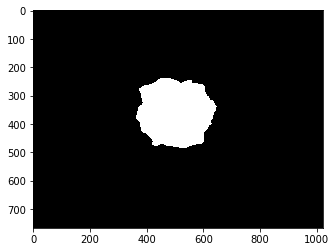

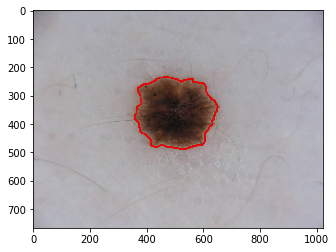

0.20006251424323448


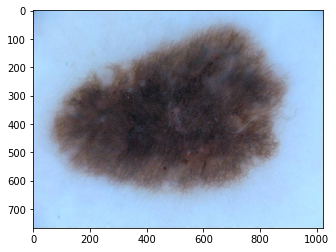

0.004350188933425525


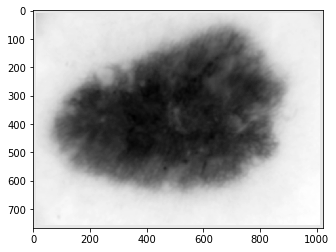

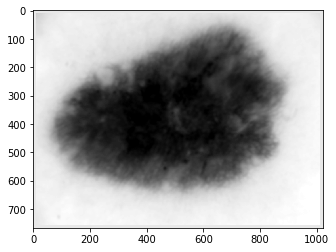

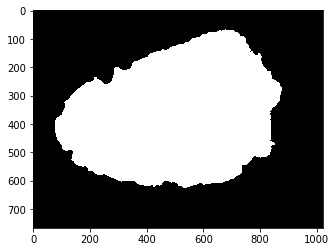

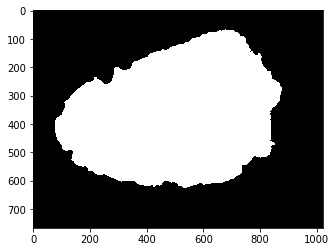

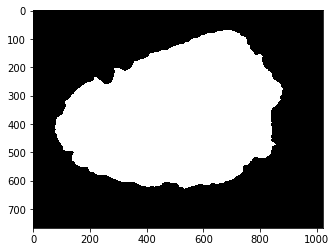

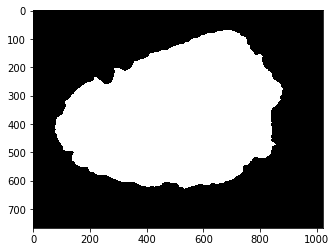

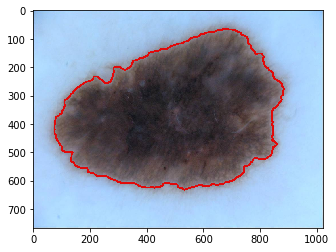

0.13255999513629535


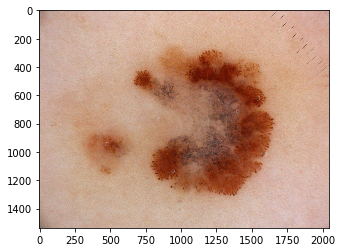

0.029063860575358074


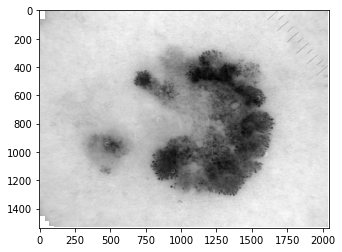

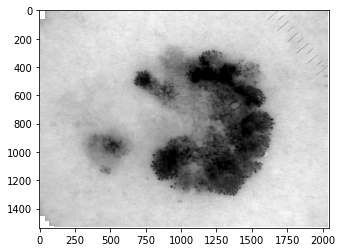

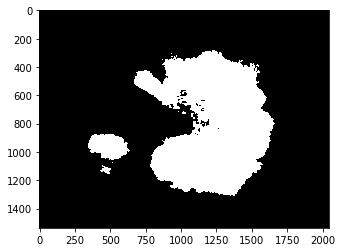

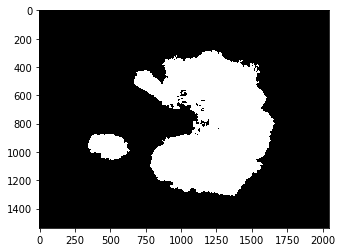

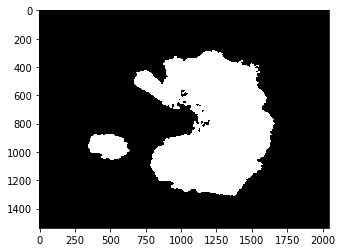

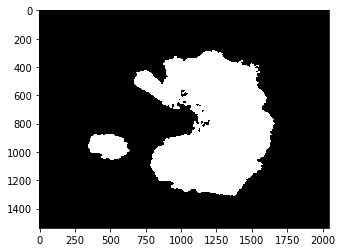

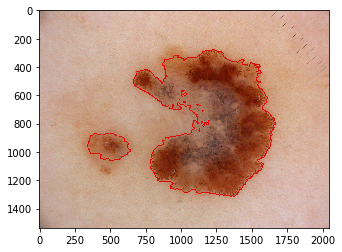

0.8162221908569336


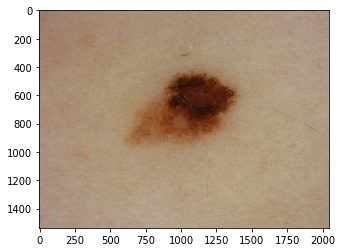

0.0022013982137044272


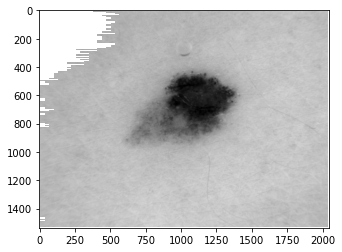

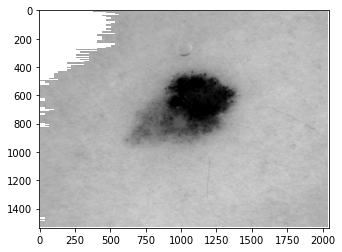

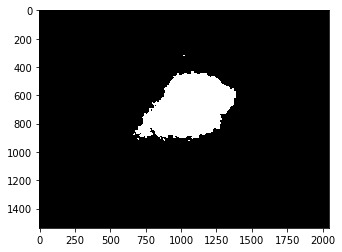

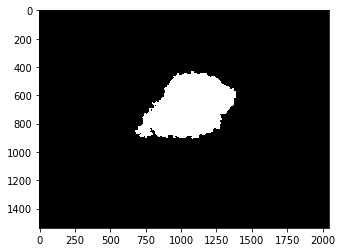

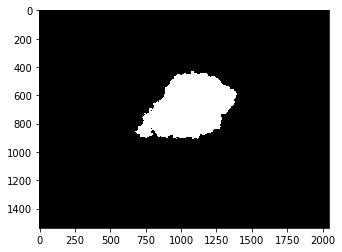

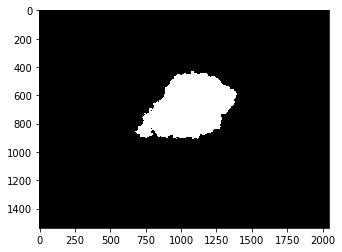

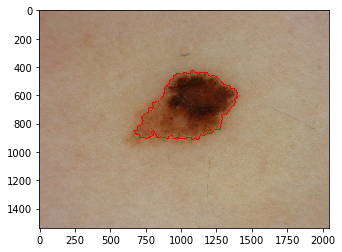

0.9486827850341797


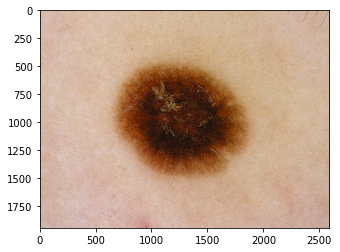

0.012710246469034191


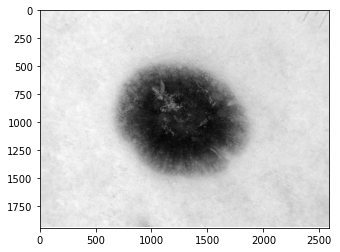

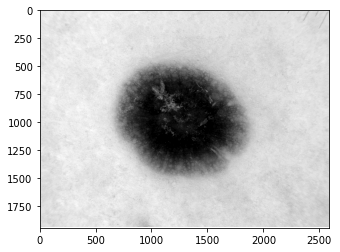

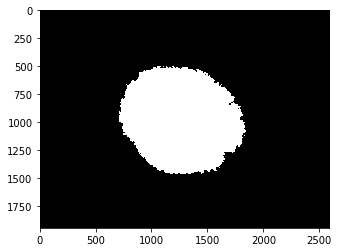

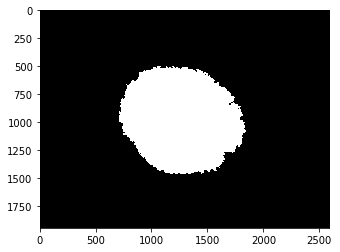

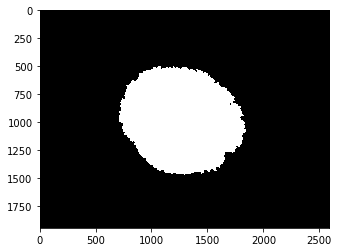

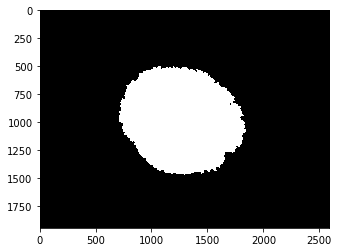

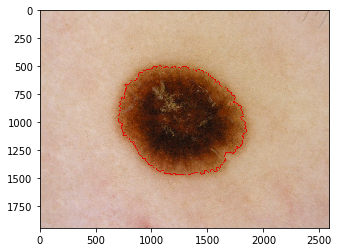

IndexError: index 2048 is out of bounds for axis 0 with size 2048

In [20]:
import glob 
f = open("diceScoreNev_RESIZE2", 'w+')
fichiers=glob.glob("nevus/*.jpg")
train = glob.glob("nevus/*.png")
for i in range(len(fichiers)):
    M = main(fichiers[i])
    trainImage = RGB2Gray(load_image(train[i]))
    #trainImage = cv2.resize(trainImage,(int(len(trainImage)/2), int(len(trainImage[0])/2)), interpolation = cv2.INTER_AREA)
    plt.imshow(M[0], cmap = 'gray')
    plt.show()
    plt.imshow(M[1], cmap = 'gray')
    plt.show()
    sc = (diceScore(M[0], trainImage))
    print(sc)
    f.write(str(sc) + '\n')
f.close()
    

In [22]:
path="nevus/ISIC_0000095.jpg"

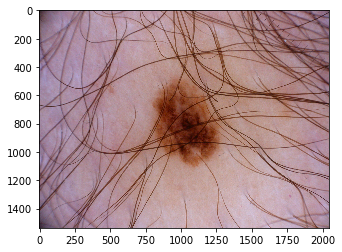

0.09438069661458333
oui


In [ ]:
main(path)

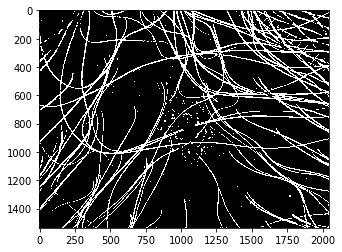

In [21]:
path = 'nevus/ISIC_0000095.jpg'
img = load_image(path)
imGray = RGB2Gray(img)
mask = createMask(imGray)
plt.imshow(mask, cmap = 'gray')
plt.show()
